In [4]:
# %matplotlib inline
import time

import numpy as np # For data manipulation
import scipy # For data manipulation
import random
import matplotlib.pyplot as plt # For doing the plotsrampy

In [5]:
import lmfit
from lmfit.models import GaussianModel

In [6]:
import rampy as rp #Charles' libraries and functions

Text(0.5, 1.0, 'Fig. 1: the raw data')

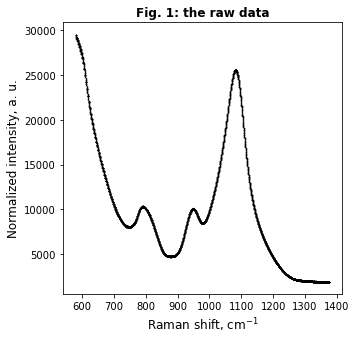

In [8]:
# get the spectrum to deconvolute, with skipping header and footer comment lines from the spectrometer
inputsp = np.genfromtxt("LS4.txt",skip_header=20, skip_footer=43) 

# create a new plot for showing the spectrum
plt.figure(figsize=(5,5))
plt.plot(inputsp[:,0],inputsp[:,1],'k.',markersize=1)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
plt.ylabel("Normalized intensity, a. u.", fontsize = 12)
plt.title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")

In [10]:
bir = np.array([(860,874),(1300,1330)]) # The regions where the baseline will be fitted
y_corr, y_base = rp.baseline(inputsp[:,0],inputsp[:,1],bir,'poly',polynomial_order=3)

In [16]:
# signal selection
lb = 867 # The lower boundary of interest
hb = 1300 # The upper boundary of interest
x = inputsp[:,0]
x_fit = x[np.where((x > lb)&(x < hb))]
y_fit = y_corr[np.where((x > lb)&(x < hb))]
ese0 = np.sqrt(abs(y_fit[:,0]))/abs(y_fit[:,0]) # the relative errors after baseline subtraction
y_fit[:,0] = y_fit[:,0]/np.amax(y_fit[:,0])*10 # normalise spectra to maximum intensity, easier to handle 
sigma = abs(ese0*y_fit[:,0]) #calculate good ese

Text(0.5, 0.98, 'Figure 2')

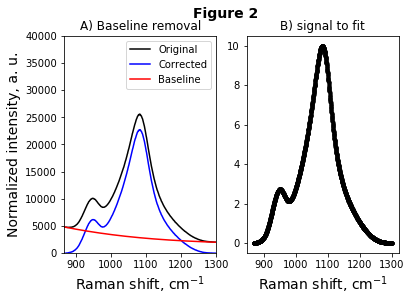

In [18]:
# create a new plot for showing the spectrum
plt.figure()
plt.subplot(1,2,1)
inp = plt.plot(x,inputsp[:,1],'k-',label='Original')
corr = plt.plot(x,y_corr,'b-',label='Corrected') #we use the sample variable because it is not already normalized...
bas = plt.plot(x,y_base,'r-',label='Baseline')
plt.xlim(lb,1300)
plt.ylim(0,40000)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.legend()
plt.title('A) Baseline removal')

plt.subplot(1,2,2)
plt.plot(x_fit,y_fit,'k.')
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.title('B) signal to fit')
#plt.tight_layout()
plt.suptitle('Figure 2', fontsize = 14,fontweight = 'bold')

In [19]:
def residual(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    a1 = pars['a1'].value
    a2 = pars['a2'].value
    a3 = pars['a3'].value
    a4 = pars['a4'].value
    a5 = pars['a5'].value
    
    f1 = pars['f1'].value
    f2 = pars['f2'].value
    f3 = pars['f3'].value
    f4 = pars['f4'].value
    f5 = pars['f5'].value 
    
    l1 = pars['l1'].value
    l2 = pars['l2'].value
    l3 = pars['l3'].value
    l4 = pars['l4'].value
    l5 = pars['l5'].value
    
    # Using the Gaussian model function from rampy
    peak1 = rp.gaussian(x,a1,f1,l1)
    peak2 = rp.gaussian(x,a2,f2,l2)
    peak3 = rp.gaussian(x,a3,f3,l3)
    peak4 = rp.gaussian(x,a4,f4,l4)
    peak5 = rp.gaussian(x,a5,f5,l5)
    
    model = peak1 + peak2 + peak3 + peak4 + peak5 # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1, peak2, peak3, peak4, peak5
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

In [20]:
params = lmfit.Parameters()
#               (Name,  Value,  Vary,   Min,  Max,  Expr)
params.add_many(('a1',   2.4,   True,  0,      None,  None),
                ('f1',   946,   True, 910,    970,  None),
                ('l1',   26,   True,  20,      50,  None),
                ('a2',   3.5,   True,  0,      None,  None),
                ('f2',   1026,  True, 990,   1070,  None),
                ('l2',   39,   True,  20,   55,  None),  
                ('a3',   8.5,    True,    7,      None,  None),
                ('f3',   1082,  True, 1070,   1110,  None),
                ('l3',   31,   True,  25,   35,  None),  
                ('a4',   2.2,   True,  0,      None,  None),
                ('f4',   1140,  True, 1110,    1160,  None),
                ('l4',   35,   True,  20,   50,  None),  
                ('a5',   2.,   True,  0,      None,  None),
                ('f5',   1211,  True, 1180,   1220,  None),
                ('l5',   28,   True,  20,   45,  None))

In [21]:
# we constrain the positions
params['f1'].vary = False
params['f2'].vary = False
params['f3'].vary = False
params['f4'].vary = False
params['f5'].vary = False

In [23]:
algo = 'nelder'  
    
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_fit[:,0])) # fit data with  nelder model from scipy

In [30]:
y_fit

array([[-0.0034274 ],
       [-0.00274339],
       [-0.00301958],
       ...,
       [-0.00174913],
       [-0.00376682],
       [-0.00439806]])

In [26]:
model = lmfit.fit_report(result.params)
yout, peak1,peak2,peak3,peak4,peak5 = residual(result.params,x_fit) # the different peaks
rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

rchi-2 = 
1898461823.9458692


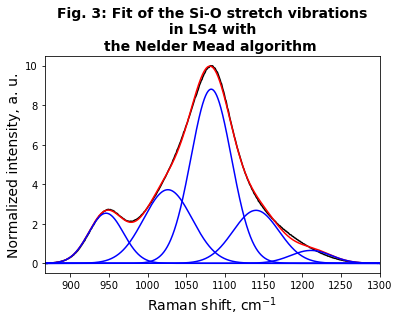

In [27]:
##### WE DO A NICE FIGURE THAT CAN BE IMPROVED FOR PUBLICATION
plt.plot(x_fit,y_fit,'k-')
plt.plot(x_fit,yout,'r-')
plt.plot(x_fit,peak1,'b-')
plt.plot(x_fit,peak2,'b-')
plt.plot(x_fit,peak3,'b-')
plt.plot(x_fit,peak4,'b-')
plt.plot(x_fit,peak5,'b-')
    
plt.xlim(lb,hb)
plt.ylim(-0.5,10.5)
plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
plt.title("Fig. 3: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Nelder Mead algorithm ",fontsize = 14,fontweight = "bold")
print("rchi-2 = \n"+str(rchi2))

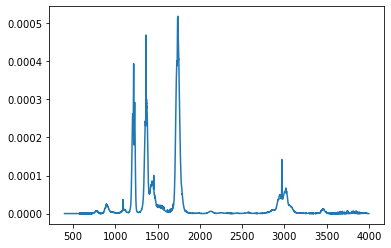

In [111]:
b_spectrum = np.genfromtxt('spectra_csv/absorbtivity/acetone.CSV', delimiter=';')
plt.plot(b_spectrum[:, 0], b_spectrum[:, 1])

In [112]:
def residual(pars, x, data=None, eps=None): #Function definition
    # unpack parameters, extract .value attribute for each parameter
    a1 = pars['I1'].value
    a2 = pars['I2'].value
    a3 = pars['I3'].value
    a4 = pars['I4'].value
    
    f1 = pars['mu1'].value
    f2 = pars['mu2'].value
    f3 = pars['mu3'].value
    f4 = pars['mu4'].value

    l1 = pars['sigma1'].value
    l2 = pars['sigma2'].value
    l3 = pars['sigma3'].value
    l4 = pars['sigma4'].value
    
    # Using the Gaussian model function from rampy
    peak1 = rp.gaussian(x,a1,f1,l1)
    peak2 = rp.gaussian(x,a2,f2,l2)
    peak3 = rp.gaussian(x,a3,f3,l3)
    peak4 = rp.gaussian(x,a4,f4,l4)
    
    model = peak1 + peak2 + peak3 + peak4 # The global model is the sum of the Gaussian peaks
    
    if data is None: # if we don't have data, the function only returns the direct calculation
        return model, peak1, peak2, peak3, peak4
    if eps is None: # without errors, no ponderation
        return (model - data)
    return (model - data)/eps # with errors, the difference is ponderated

In [113]:
params = lmfit.Parameters()
#               (Name,  Value,  Vary,   Min,  Max,  Expr)
params.add_many(('I1',   84 * 10 / 124,   True,  0,      None,  None),
                ('mu1',   3062,   True, 2962,    3162,  None),
                ('sigma1',   10,   True,  10,      100,  None),
                ('I2',   12 * 10 / 124,   True,  0,      None,  None),
                ('mu2',   1483,  True, 1384,   1584,  None),
                ('sigma2',   10,   True,  10,   100,  None),  
                ('I3',   12.* 10 / 124,    True,    0,      None,  None),
                ('mu3',   1038,  True, 938,   1138,  None),
                ('sigma3',   10,   True,  10,   100,  None),  
                ('I4',   124 * 10 / 124,   True,  0,      None,  None),
                ('mu4',   674,  True, 574,    774,  None),
                ('sigma4',   10,   True,  10,   100,  None))
len(params)

12

In [124]:
%matplotlib qt
algo = 'nelder'  
x_fit = b_spectrum[:, 0]
y_fit = b_spectrum[:, 1]

# units_constant = gas_constant * 296 / 101.3e3 * 1e10 * 1e-5
y_smo = rp.smooth(x_fit, y_fit, method="bartlett", window_length=101)
norm_constant = np.max(y_smo) / 10
y_smo /= norm_constant # normalise spectra to maximum intensity, easier to handle 

plt.figure(figsize=(20, 10))

# plt.plot(x_fit, y_fit)
plt.plot(x_fit, y_smo)
plt.s

In [117]:
result = lmfit.minimize(residual, params, method = algo, args=(x_fit, y_smo), tol=1e-1) # fit data with  nelder model from scipy

In [118]:
model = lmfit.fit_report(result.params)
yout, peak1, peak2, peak3, peak4 = residual(result.params,x_fit) # the different peaks
# rchi2 = (1/(float(len(y_fit))-15-1))*np.sum((y_fit - yout)**2/sigma**2) # calculation of the reduced chi-square

Text(0, 0.5, 'Normalized intensity, a. u.')

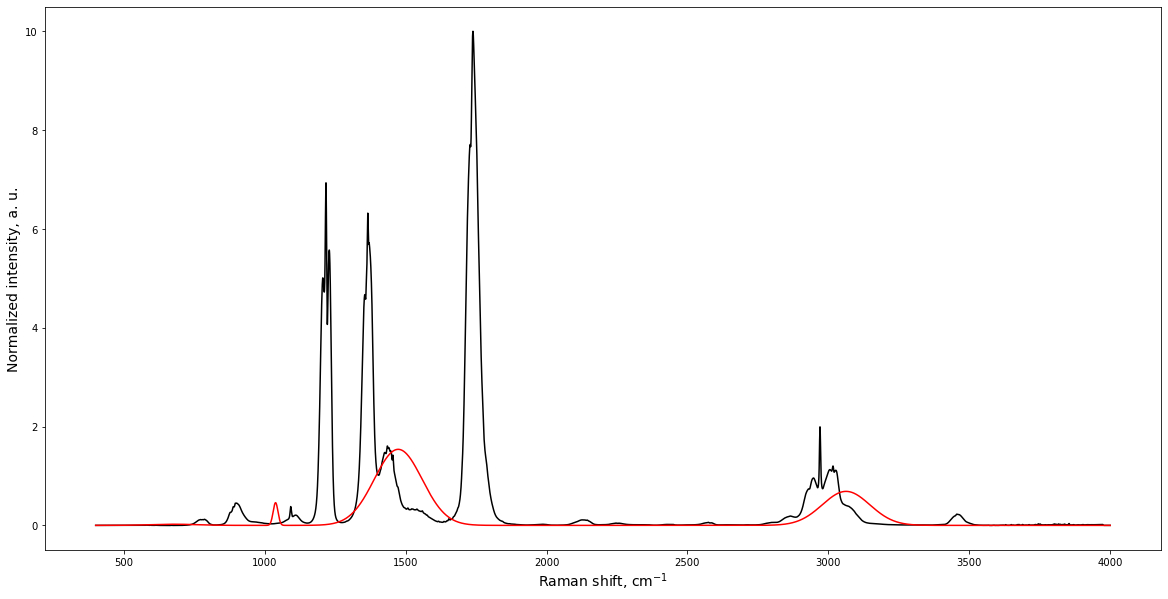

In [119]:
plt.figure(figsize=(20, 10))
plt.plot(x_fit,y_smo,'k-')
plt.plot(x_fit,yout,'r-')
# plt.plot(x_fit,peak1,'b-')
# plt.plot(x_fit,peak2,'b-')
# plt.plot(x_fit,peak3,'b-')
# plt.plot(x_fit,peak4,'b-')
# plt.plot(x_fit,peak5,'b-')

plt.xlabel("Raman shift, cm$^{-1}$", fontsize = 14)
plt.ylabel("Normalized intensity, a. u.", fontsize = 14)
# plt.title("Fig. 3: Fit of the Si-O stretch vibrations\n in LS4 with \nthe Nelder Mead algorithm ",fontsize = 14,fontweight = "bold")
# print("rchi-2 = \n"+str(rchi2))

In [120]:
result.params

name,value,initial value,min,max,vary
I1,0.68838784,6.774193548387097,0.00000000,inf,True
mu1,3062.60164,3062,2962.00000,3162.00000,True
sigma1,99.2664870,10,10.0000000,100.000000,True
I2,1.53951548,0.967741935483871,0.00000000,inf,True
mu2,1473.43617,1483,1384.00000,1584.00000,True
sigma2,99.9767709,10,10.0000000,100.000000,True
I3,0.45968928,0.967741935483871,0.00000000,inf,True
mu3,1038.27266,1038,938.000000,1138.00000,True
sigma3,10.0854840,10,10.0000000,100.000000,True
I4,0.02325844,10.0,0.00000000,inf,True


In [107]:
from scipy.constants import gas_constant

units_constant = gas_constant * 296 / 101.3e3 * 1e10

i1 = result.params['I1'].value * units_constant * norm_constant * 1e-5
sigma1 = result.params['sigma1'].value
psi1 = i1 * sigma1 * np.sqrt(2 * np.pi)

i2 = result.params['I3'].value * units_constant * norm_constant * 1e-5
sigma2 = result.params['sigma3'].value
psi2 = i2 * sigma2 * np.sqrt(2 * np.pi)

In [108]:
psi1, psi2

(150849.323192918, 16451.35093089597)

In [80]:
12 / 84

0.14285714285714285

In [109]:
16451 / 150849


0.10905607594349316